<a href="https://www.kaggle.com/code/dimasprayoga/telecom-customer-churn-prediction?scriptVersionId=258039504" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Core
import warnings
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Stats tests
from scipy.stats import chi2_contingency, ttest_ind

# Preprocessing & model selection
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

# (Opsional) tata-rias plot & filter warning
warnings.filterwarnings("ignore")
sns.set(style="whitegrid", palette="Set1")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-churn-dataset/customer_churn_data.csv


# Load Data

In [2]:
churn = pd.read_csv('/kaggle/input/customer-churn-dataset/customer_churn_data.csv')

In [3]:
# Structure
churn.info()
churn.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5880 entries, 0 to 5879
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5880 non-null   object 
 1   gender            5880 non-null   object 
 2   SeniorCitizen     5880 non-null   int64  
 3   Partner           5880 non-null   object 
 4   Dependents        5880 non-null   object 
 5   tenure            5880 non-null   int64  
 6   PhoneService      5880 non-null   object 
 7   MultipleLines     5880 non-null   object 
 8   InternetService   5880 non-null   object 
 9   OnlineSecurity    5880 non-null   object 
 10  OnlineBackup      5880 non-null   object 
 11  DeviceProtection  5880 non-null   object 
 12  TechSupport       5880 non-null   object 
 13  StreamingTV       5880 non-null   object 
 14  StreamingMovies   5880 non-null   object 
 15  Contract          5880 non-null   object 
 16  PaperlessBilling  5880 non-null   object 


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,5880.000000,5880.000000,5880.000000,5880.000000
mean,0.500680,36.549150,70.157779,2566.813165
std,0.500042,20.909674,28.804615,1910.017743
min,0.000000,1.000000,20.000000,20.030000
25%,0.000000,18.000000,45.717500,1020.217500
50%,1.000000,37.000000,70.155000,2136.445000
75%,1.000000,55.000000,95.457500,3767.665000
max,1.000000,72.000000,119.990000,8589.600000


In [4]:
churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,CUST0000,Male,0,No,Yes,23,No,No phone service,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer,49.85,1146.55,No
1,CUST0001,Female,0,Yes,No,43,No,No phone service,DSL,Yes,...,Yes,No,Yes,No,Month-to-month,No,Mailed check,100.70,4330.10,Yes
2,CUST0002,Male,1,No,No,51,Yes,No,DSL,No,...,Yes,Yes,No,No,One year,No,Electronic check,97.33,4963.83,Yes
3,CUST0003,Male,1,No,No,72,Yes,Yes,DSL,Yes,...,Yes,No,No,No,Month-to-month,No,Credit card,101.38,7299.36,No
4,CUST0004,Male,1,No,No,25,Yes,Yes,DSL,No,...,No,Yes,No,Yes,Month-to-month,No,Electronic check,52.22,1305.50,Yes


# Data Cleaning

In [5]:
# Cleaning (strip column, convert TotalCharges, dsb.)
churn.columns = churn.columns.str.strip()
churn["TotalCharges"] = pd.to_numeric(churn["TotalCharges"], errors="coerce").fillna(0)

In [6]:
# Drop irrelevant columns
churn = churn.drop("customerID", axis=1)

In [7]:
# Standardize category values
cols_replace = [
    "MultipleLines", 
    "OnlineSecurity", "OnlineBackup", 
    "DeviceProtection", "TechSupport", 
    "StreamingTV", "StreamingMovies"
]

for col in cols_replace:
    churn[col] = churn[col].replace(
        {"No internet service": "No", "No phone service": "No"}
    )

In [8]:
print(churn.columns.tolist())

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [9]:
# Double-check the cleaning results
print(churn.info())
print(churn.isnull().sum())

#Check data size (rows x columns)
churn.info()
print("Ukuran dataset \n baris dan kolom :", churn.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5880 entries, 0 to 5879
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5880 non-null   object 
 1   SeniorCitizen     5880 non-null   int64  
 2   Partner           5880 non-null   object 
 3   Dependents        5880 non-null   object 
 4   tenure            5880 non-null   int64  
 5   PhoneService      5880 non-null   object 
 6   MultipleLines     5880 non-null   object 
 7   InternetService   5880 non-null   object 
 8   OnlineSecurity    5880 non-null   object 
 9   OnlineBackup      5880 non-null   object 
 10  DeviceProtection  5880 non-null   object 
 11  TechSupport       5880 non-null   object 
 12  StreamingTV       5880 non-null   object 
 13  StreamingMovies   5880 non-null   object 
 14  Contract          5880 non-null   object 
 15  PaperlessBilling  5880 non-null   object 
 16  PaymentMethod     5880 non-null   object 


# Exploratory Data Analysis (EDA)

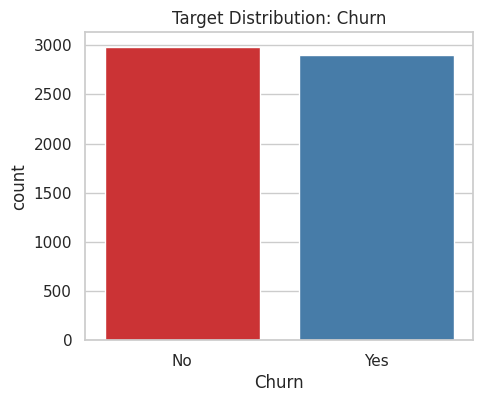

Churn
No     50.714286
Yes    49.285714
Name: proportion, dtype: float64


In [10]:
# 1. Target Churn Distribution
plt.figure(figsize=(5,4))
sns.countplot(x="Churn", data=churn, palette="Set1")   # menghitung jumlah churn vs tidak churn
plt.title("Target Distribution: Churn")
plt.show()

# Churn percentage
print(churn["Churn"].value_counts(normalize=True) * 100)  # persentase churn dalam %

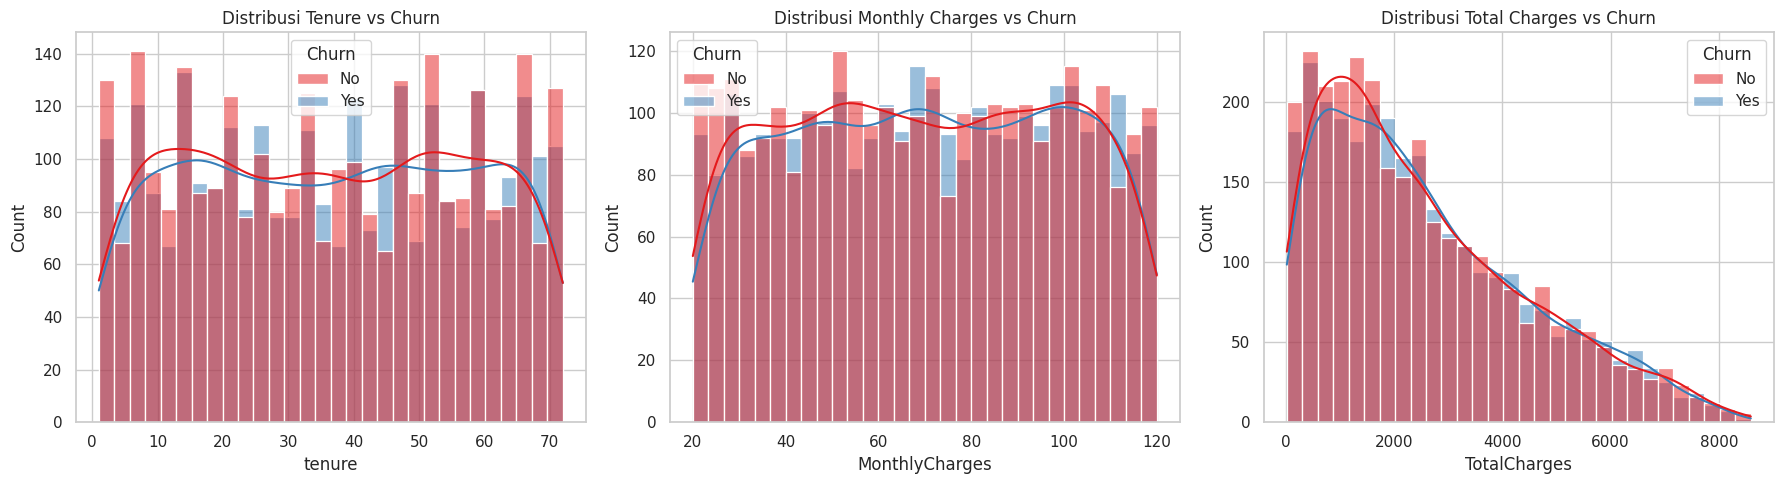

In [11]:
# Numerical Distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(churn, x="tenure", hue="Churn", bins=30, kde=True, ax=axes[0], palette="Set1")
axes[0].set_title("Distribusi Tenure vs Churn")

sns.histplot(churn, x="MonthlyCharges", hue="Churn", bins=30, kde=True, ax=axes[1], palette="Set1")
axes[1].set_title("Distribusi Monthly Charges vs Churn")

sns.histplot(churn, x="TotalCharges", hue="Churn", bins=30, kde=True, ax=axes[2], palette="Set1")
axes[2].set_title("Distribusi Total Charges vs Churn")

plt.tight_layout()
plt.show()

# 4) (opsional) muted FutureWarning from seaborn/pandas
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

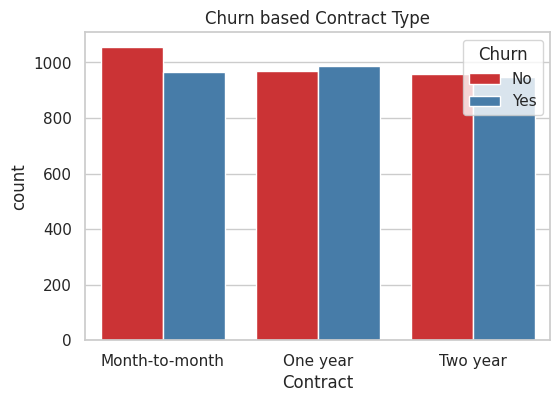

In [12]:
# Contractual Relationship with Churn

plt.figure(figsize=(6,4))
sns.countplot(x="Contract", hue="Churn", data=churn, palette="Set1")
plt.title("Churn based Contract Type")
plt.show()

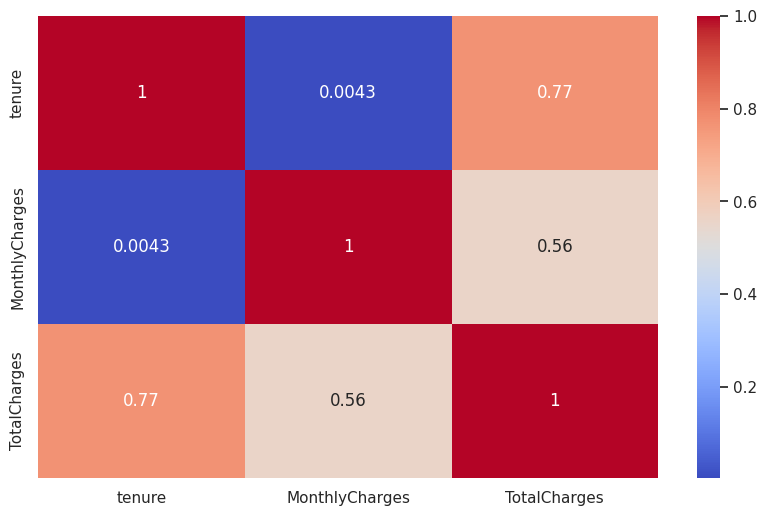

In [13]:
# Correlation Numerik

plt.figure(figsize=(10,6))
sns.heatmap(churn[["tenure","MonthlyCharges","TotalCharges"]].corr(), annot=True, cmap="coolwarm")
plt.show()


 📊 Correlation Heatmap Explanation

The heatmap below shows the **correlation coefficients** between three numerical variables in the dataset:  
- `tenure` → how long a customer has been subscribed (in months)  
- `MonthlyCharges` → the monthly fee of the subscription  
- `TotalCharges` → the accumulated charges paid by the customer  

🔹 How to Read the Heatmap
- **Color Scale**  
  - **Red (closer to +1)** → strong **positive correlation**  
  - **Blue (closer to -1)** → strong **negative correlation**  
  - **White (close to 0)** → almost no correlation  

- **Diagonal (all = 1)**  
  - Each variable compared to itself → always correlation = 1  
  - Example: `tenure` vs `tenure`, `MonthlyCharges` vs `MonthlyCharges`  

- **Off-diagonal values**  
  - These are the actual correlations between **different variables**  


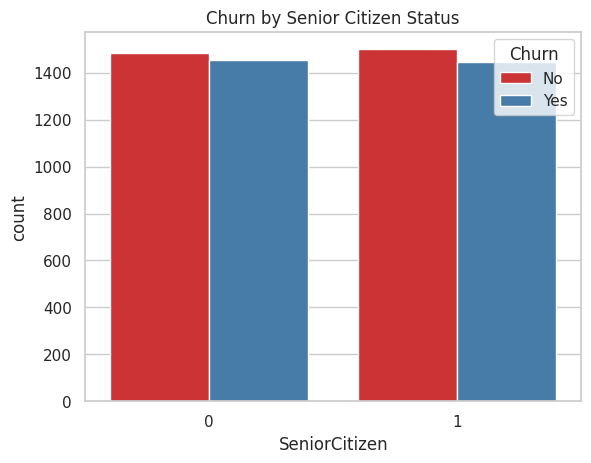

In [14]:
# Demographics Analysis (Analisis Demografi)

# Distribution of churn by demographics
sns.countplot(x="SeniorCitizen", hue="Churn", data=churn, palette="Set1")
plt.title("Churn by Senior Citizen Status")
plt.show()



EN: Older customers (SeniorCitizen = 1) often show a higher churn rate.

ID: Pelanggan lansia (SeniorCitizen = 1) sering memiliki tingkat churn lebih tinggi.

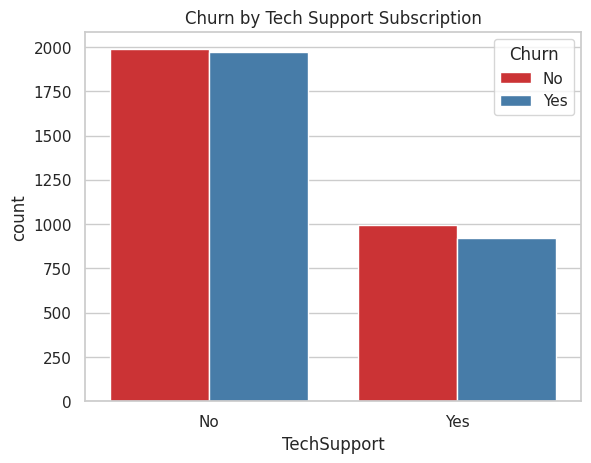

In [15]:
# Additional Services Analysis (Analisis Layanan Tambahan)

# Churn vs Tech Support service
sns.countplot(x="TechSupport", hue="Churn", data=churn, palette="Set1")
plt.title("Churn by Tech Support Subscription")
plt.show()


EN: Customers with technical support services are less likely to churn.

ID: Pelanggan dengan layanan dukungan teknis cenderung lebih jarang churn.

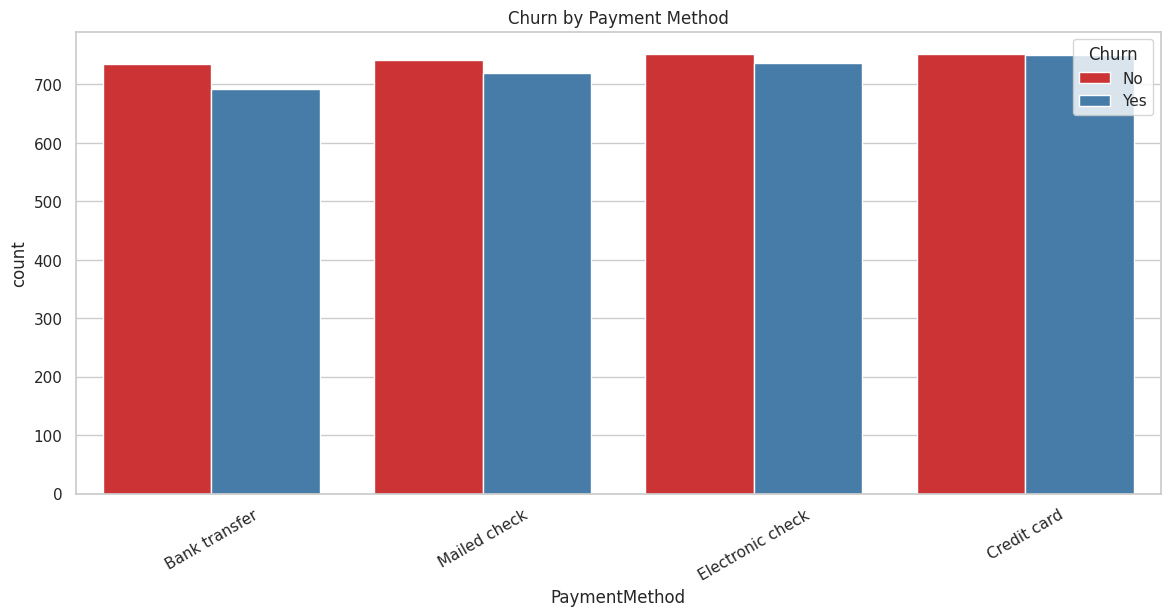

In [16]:
# Payment Method Analysis (Analisis Metode Pembayaran)

# Churn vs Payment Method
plt.figure(figsize=(14,6))
sns.countplot(x="PaymentMethod",
              hue="Churn", 
              data=churn,
              palette="Set1",
              dodge=True,
              width=0.8)
plt.title("Churn by Payment Method")
plt.xticks(rotation=30)
plt.show()


EN: Customers paying via Electronic Check often have the highest churn rate.

ID: Pelanggan yang membayar dengan Electronic Check biasanya memiliki churn rate tertinggi.

In [17]:
# Statistical Significance Testing (Uji Signifikansi Statistik)
# Chi-square test for categorical variables

# Chi-square test: Contract vs Churn
contingency_table = pd.crosstab(churn["Contract"], churn["Churn"])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square Test: Contract vs Churn")
print("Chi2 =", chi2, ", p-value =", p)

Chi-square Test: Contract vs Churn
Chi2 = 3.209033527324814 , p-value = 0.20098665550238531


EN: If the p-value < 0.05, it means contract type has a significant effect on churn.

ID: Jika p-value < 0.05, artinya jenis kontrak berpengaruh signifikan terhadap churn.

In [18]:
# T-test for numeric variables

churn_yes = churn[churn["Churn"]=="Yes"]["MonthlyCharges"]
churn_no  = churn[churn["Churn"]=="No"]["MonthlyCharges"]

t_stat, p = ttest_ind(churn_yes, churn_no, equal_var=False)

print("T-test MonthlyCharges: t =", t_stat, ", p-value =", p)

T-test MonthlyCharges: t = 1.1479202808684639 , p-value = 0.25104820646082476


EN: If p-value < 0.05, churned customers pay significantly different monthly charges compared to retained customers.

ID: Jika p-value < 0.05, biaya bulanan pelanggan yang churn berbeda signifikan dengan pelanggan yang bertahan.

EN: Adding demographic, service, and payment method analysis, along with statistical testing, strengthens the portfolio by showing not only visualization but also evidence of statistical significance.

ID: Dengan menambahkan analisis demografi, layanan tambahan, metode pembayaran, serta uji statistik, portofolio Anda jadi lebih kuat karena tidak hanya menampilkan visualisasi tapi juga bukti signifikansi statistik.

# Feature Enginnering - Customer Churn Prediction

In [19]:
# Encoding Categorical Variables
# Encode binary variables
binary_cols = ["gender", "Partner", "Dependents", "PhoneService", 
               "PaperlessBilling", "Churn"]

le = LabelEncoder()
for col in binary_cols:
    churn[col] = le.fit_transform(churn[col])

# One-Hot Encoding for categorical with >2 categories
churn = pd.get_dummies(churn, columns=["Contract", "PaymentMethod", "InternetService"], drop_first=True)

In [20]:
# Scaling Numerical Variables
scaler = StandardScaler()
churn[["tenure", "MonthlyCharges", "TotalCharges"]] = scaler.fit_transform(
    churn[["tenure", "MonthlyCharges", "TotalCharges"]]
)

In [21]:
# Train-Test Split

X = churn.drop("Churn", axis=1)
y = churn["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
# 1) Shapes (EN: confirm split; ID: konfirmasi pembagian train-test)
print("=== DATA SHAPES ===")
print(f"X_train shape: {X_train.shape}")
print(f"X_test  shape: {X_test.shape}")
print(f"y_train distribution: {y_train.value_counts().to_dict()}")
print(f"y_test  distribution: {y_test.value_counts().to_dict()}")
print()

=== DATA SHAPES ===
X_train shape: (4704, 23)
X_test  shape: (1176, 23)
y_train distribution: {0: 2386, 1: 2318}
y_test  distribution: {0: 596, 1: 580}



In [23]:
# 2) Column overview (EN: see encoded features; ID: lihat fitur hasil encoding)
print("=== FEATURE COLUMNS (first 25) ===")
cols = X_train.columns.tolist()
print(cols[:25], "..." if len(cols) > 25 else "")
print("Total number of features:", len(cols))
print()

=== FEATURE COLUMNS (first 25) ===
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'InternetService_Fiber optic', 'InternetService_No'] 
Total number of features: 23



In [24]:
# 3) Sample rows (EN: confirm numeric-only matrix; ID: pastikan hanya numerik)
print("=== SAMPLE OF X_train ===")
display(X_train.head())

=== SAMPLE OF X_train ===


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaperlessBilling,MonthlyCharges,TotalCharges,Contract_One year,Contract_Two year,PaymentMethod_Credit card,PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No
4701,1,1,0,1,0.452023,1,Yes,No,No,No,...,1,0.468445,0.670777,True,False,False,False,False,False,True
1503,1,1,1,1,0.308537,0,No,Yes,No,No,...,1,0.338246,0.454949,False,True,False,True,False,False,False
5063,0,0,0,0,0.212879,1,Yes,No,No,No,...,1,1.209014,0.909685,False,True,False,True,False,False,True
4780,1,0,0,1,0.356365,0,No,Yes,No,Yes,...,0,-0.503010,-0.061436,False,True,False,True,False,True,False
2096,0,0,1,1,-0.313238,0,No,No,No,No,...,1,-0.508912,-0.472189,True,False,False,True,False,False,True


In [25]:
# 4) Dtypes check (EN: ensure no 'object'; ID: pastikan tidak ada tipe object)
print("\n=== DTYPES CHECK ===")
print(X_train.dtypes.value_counts())


=== DTYPES CHECK ===
object     7
bool       7
int64      6
float64    3
Name: count, dtype: int64


In [26]:
# 5) Target balance (EN: class proportion; ID: proporsi kelas)
print("\n=== TARGET DISTRIBUTION (overall) ===")
target_pct = y.value_counts(normalize=True).mul(100).rename({0:"No", 1:"Yes"})
print(target_pct.round(2).astype(str) + "%")


=== TARGET DISTRIBUTION (overall) ===
Churn
No     50.71%
Yes    49.29%
Name: proportion, dtype: object


* Shapes: X_train ~80% of rows, X_test ~20% → split is correct.
* (ID): Proporsi train ~80% dan test ~20% → pembagian benar.

* Feature columns: Many dummy variables (e.g., Contract_One year) appear.
* (ID): Kolom dummy hasil One-Hot terlihat, jumlah fitur meningkat.

* Sample of X_train: All numeric (int/float), no strings.
* (ID): Semua numerik (int/float), tidak ada string.

* Dtypes check: No object type.
* (ID): Tidak ada tipe object.

* Target distribution: Typically ~27% churn, ~73% non-churn (imbalanced).
* (ID): Biasanya ~27% churn, ~73% non-churn (imbalans).

# Analysis & Modeling – Baseline Logistic Regression

In [27]:
# Load & Cleaning 
churn = pd.read_csv("/kaggle/input/customer-churn-dataset/customer_churn_data.csv")

In [28]:
# Hapus spasi nama kolom
churn.columns = churn.columns.str.strip()

In [29]:
# Ubah TotalCharges jadi numerik
churn["TotalCharges"] = pd.to_numeric(churn["TotalCharges"], errors="coerce").fillna(0)

In [30]:
# Standarisasi kategori
cols_replace = ["MultipleLines", "OnlineSecurity", "OnlineBackup", 
                "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]

for col in cols_replace:
    churn[col] = churn[col].replace({"No internet service":"No", "No phone service":"No"})

In [31]:
# 3. Feature Engineering (Encoding)
# Label Encoding untuk kolom binary
binary_cols = ["gender", "Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"]

le = LabelEncoder()
for col in binary_cols:
    churn[col] = le.fit_transform(churn[col])

# One-Hot Encoding untuk kategori dengan >2 unique values
churn = pd.get_dummies(churn, columns=[
    "Contract", "PaymentMethod", "InternetService",
    "MultipleLines", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"
], drop_first=True)


In [32]:
# 4. Split Feature & Target

X = churn.drop("Churn", axis=1)
y = churn["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [33]:
# 5. Scaling Numerik

scaler = StandardScaler()
X_train[["tenure", "MonthlyCharges", "TotalCharges"]] = scaler.fit_transform(
    X_train[["tenure", "MonthlyCharges", "TotalCharges"]]
)
X_test[["tenure", "MonthlyCharges", "TotalCharges"]] = scaler.transform(
    X_test[["tenure", "MonthlyCharges", "TotalCharges"]]
)

In [34]:
# Drop ID column (not useful for modeling)
if "customerID" in churn.columns:
    churn = churn.drop("customerID", axis=1)

In [35]:
# 6. Modeling Logistic Regression
# Features & target
X = churn.drop("Churn", axis=1)
y = churn["Churn"]

# Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [36]:
# --- drop ID column from both sets, if present ---
cols_to_drop = [c for c in ["customerID"] if c in X_train.columns]
X_train = X_train.drop(columns=cols_to_drop, errors="ignore")
X_test  = X_test.drop(columns=cols_to_drop, errors="ignore")

# (re)fit the model after fixing columns
logreg = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")
logreg.fit(X_train, y_train)

# predict
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

In [37]:
# Align X_test to training feature names (fills missing with 0, drops extras)
X_test = X_test.reindex(columns=logreg.feature_names_in_, fill_value=0)

In [38]:
# RESULTS & EVALUATION (EN + ID)

# 1) Text metrics (EN: summary metrics; ID: ringkasan metrik)
print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, digits=3))

auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {auc:.3f}")



=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0      0.476     0.468     0.472       596
           1      0.463     0.471     0.467       580

    accuracy                          0.469      1176
   macro avg      0.469     0.469     0.469      1176
weighted avg      0.470     0.469     0.469      1176

ROC-AUC: 0.466


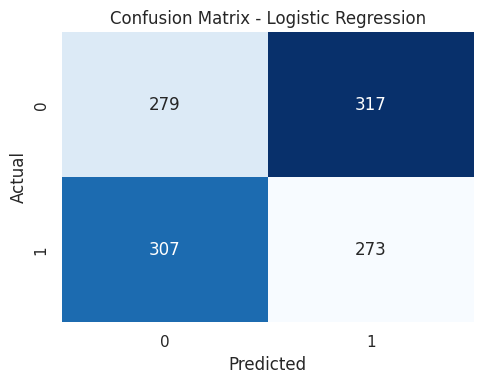

In [39]:
# 2) Confusion Matrix (EN: errors by class; ID: salah/benar per kelas)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

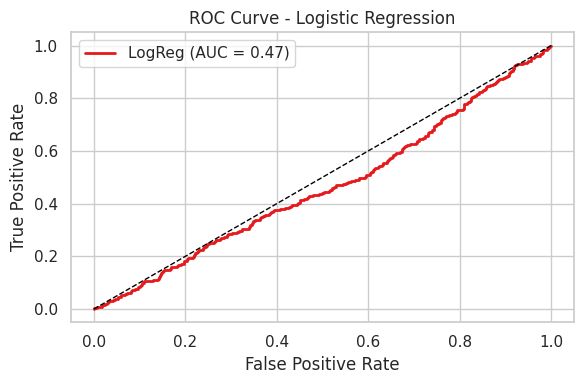

In [40]:
# 3) ROC Curve (EN: trade-off visualization; ID: visualisasi trade-off)
fpr, tpr, thr = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"LogReg (AUC = {auc:.2f})", lw=2)
plt.plot([0,1],[0,1],"k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
# 4) Top coefficients as odds ratios (EN: feature impact; ID: dampak fitur)
#    EN: >1 increases churn odds; <1 decreases odds
#    ID: >1 menaikkan peluang churn; <1 menurunkan
coef = pd.Series(logreg.coef_[0], index=logreg.feature_names_in_)
odds = np.exp(coef).sort_values(ascending=False)

top_pos = odds.head(10)     # EN: strongest positive drivers; ID: pendorong churn terkuat
top_neg = odds.tail(10)     # EN: strongest protective factors; ID: penurun risiko terkuat

print("\n=== TOP POSITIVE ODDS (increase churn) / Pendorong Churn ===")
display(top_pos.to_frame("odds_ratio"))

print("=== TOP NEGATIVE ODDS (decrease churn) / Penurun Risiko ===")
display(top_neg.to_frame("odds_ratio"))


=== TOP POSITIVE ODDS (increase churn) / Pendorong Churn ===


,odds_ratio
Contract_One year,1.105348
OnlineBackup_Yes,1.085849
DeviceProtection_Yes,1.078186
Partner,1.076181
gender,1.069030
PaymentMethod_Credit card,1.064979
OnlineSecurity_Yes,1.032880
PaperlessBilling,1.026083
PaymentMethod_Electronic check,1.025346
InternetService_No,1.021594


=== TOP NEGATIVE ODDS (decrease churn) / Penurun Risiko ===


,odds_ratio
InternetService_Fiber optic,1.004777
TotalCharges,1.000058
MonthlyCharges,0.998234
tenure,0.996256
StreamingMovies_Yes,0.975447
PhoneService,0.969686
PaymentMethod_Mailed check,0.958003
StreamingTV_Yes,0.943765
MultipleLines_Yes,0.940270
TechSupport_Yes,0.933062


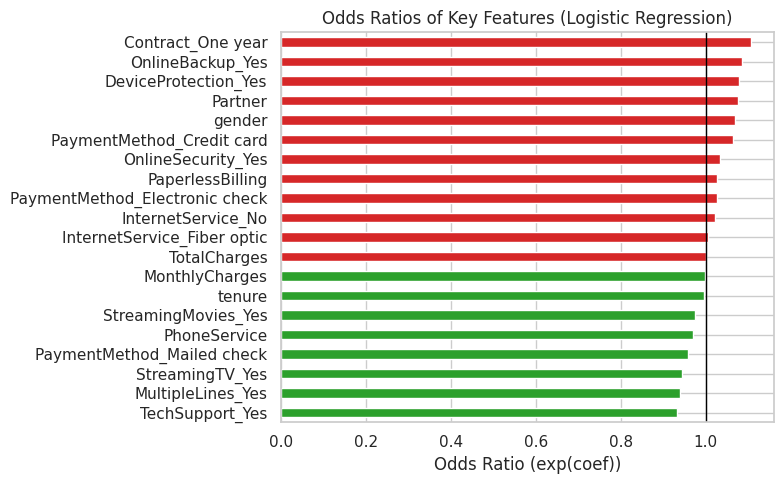

In [42]:
#  Barplot for top features
plt.figure(figsize=(8,5))
top_plot = pd.concat([top_pos, top_neg]).sort_values()
top_plot.plot(kind="barh", color=np.where(top_plot>1, "#d62728", "#2ca02c"))
plt.axvline(1, color="k", lw=1)
plt.title("Odds Ratios of Key Features (Logistic Regression)")
plt.xlabel("Odds Ratio (exp(coef))")
plt.tight_layout()
plt.show()

Precision / Recall / F1 (class 1 = Churn)
* EN: Focus on recall for churn to catch as many churners as possible.
* ID: Fokus pada recall kelas “Churn” agar sedikit pelanggan churn yang lolos.

ROC-AUC ≥ 0.80 → model sudah cukup baik memisahkan churn vs non-churn.

Odds Ratio
* EN: >1 increases churn odds, <1 decreases; larger distance from 1 = stronger effect.
* ID: >1 menaikkan peluang churn, <1 menurunkan; makin jauh dari 1 makin kuat efeknya.

#  Analysis & Modeling – Random Forest Classifier

In [43]:
# Load & Cleaning 
churn = pd.read_csv("/kaggle/input/customer-churn-dataset/customer_churn_data.csv")

In [44]:
# Hapus spasi nama kolom
churn.columns = churn.columns.str.strip()

In [45]:
# Ubah TotalCharges jadi numerik
churn["TotalCharges"] = pd.to_numeric(churn["TotalCharges"], errors="coerce").fillna(0)

In [46]:
# Standarisasi kategori
cols_replace = ["MultipleLines", "OnlineSecurity", "OnlineBackup", 
                "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]

for col in cols_replace:
    churn[col] = churn[col].replace({"No internet service":"No", "No phone service":"No"})

In [47]:
print("Churn distribution:\n", churn["Churn"].value_counts())
print("\nDtypes:\n", churn.dtypes.value_counts())
print("\nAny object types left?:", churn.select_dtypes("object").columns.tolist())


Churn distribution:
 Churn
No     2982
Yes    2898
Name: count, dtype: int64

Dtypes:
 object     17
int64       2
float64     2
Name: count, dtype: int64

Any object types left?: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


In [48]:
print("Churn distribution:\n", y.value_counts(normalize=True))

print("\nFeature types:\n", X.dtypes.value_counts())

print("\nAny object left?:", X.select_dtypes(include=['object']).columns.tolist())

print("\nCheck NaN in train/test:",
      X_train.isna().sum().sum(),
      X_test.isna().sum().sum())

print("\nX_train shape:", X_train.shape, "| X_test shape:", X_test.shape)

# Only check inf for numeric columns
for df_name, df in [("X_train", X_train), ("X_test", X_test)]:
    numeric_df = df.select_dtypes(include=[np.number])
    inf_count = np.isinf(numeric_df).sum().sum()
    print(f"Check inf in {df_name}: {inf_count}")


Churn distribution:
 Churn
0    0.507143
1    0.492857
Name: proportion, dtype: float64

Feature types:
 bool       14
int64       7
float64     2
Name: count, dtype: int64

Any object left?: []

Check NaN in train/test: 0 0

X_train shape: (4704, 23) | X_test shape: (1176, 23)
Check inf in X_train: 0
Check inf in X_test: 0


In [49]:
# 1) Train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,   # number of trees
    max_depth=None,     # allow full depth
    random_state=42,
    class_weight="balanced",  # handle imbalance
    n_jobs=-1           # use all cores
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

In [50]:
# 2) Prediction
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

In [51]:
# 3) Evaluation Metrics
print("=== Classification Report (Random Forest) ===")
print(classification_report(y_test, y_pred_rf, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

=== Classification Report (Random Forest) ===
              precision    recall  f1-score   support

           0      0.494     0.529     0.511       596
           1      0.478     0.443     0.460       580

    accuracy                          0.486      1176
   macro avg      0.486     0.486     0.485      1176
weighted avg      0.486     0.486     0.485      1176

ROC-AUC: 0.4783600439713029


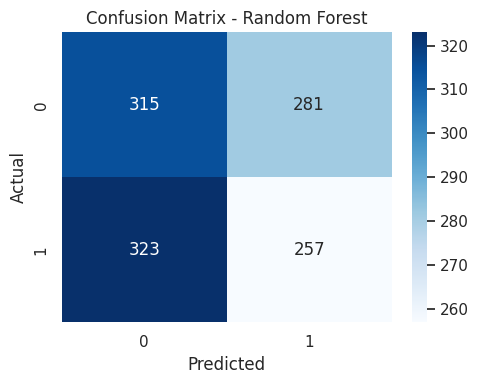

In [52]:
# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

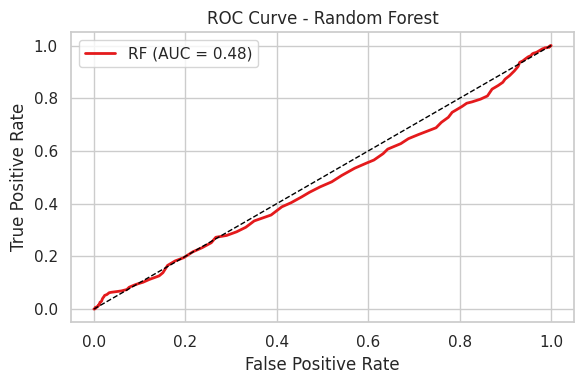

In [53]:
# ROC Curve
fpr, tpr, thr = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"RF (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})", lw=2)
plt.plot([0,1],[0,1],"k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.tight_layout()
plt.show()


=== Top 15 Important Features (Random Forest) ===


,importance
MonthlyCharges,0.182160
TotalCharges,0.180528
tenure,0.159394
PaperlessBilling,0.031406
gender,0.030570
SeniorCitizen,0.030382
Dependents,0.030158
Partner,0.029637
PhoneService,0.026076
Contract_Two year,0.023474


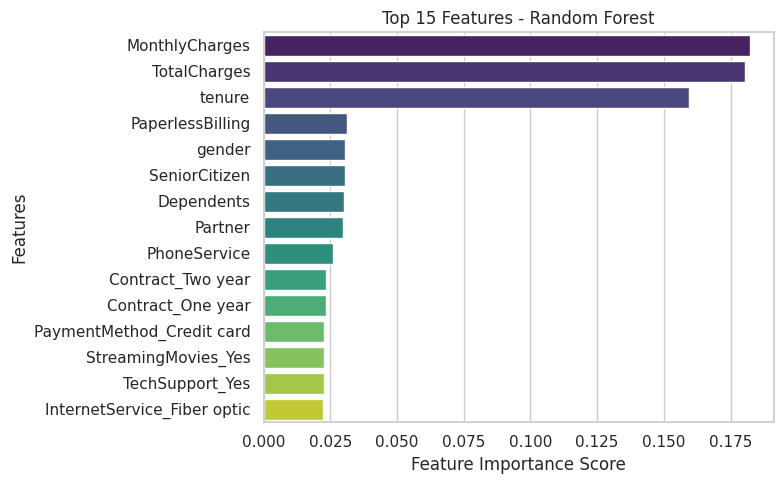

In [54]:
# 4) Feature Importance
importances = pd.Series(rf.feature_importances_, index=rf.feature_names_in_)
top_features = importances.sort_values(ascending=False).head(15)

print("\n=== Top 15 Important Features (Random Forest) ===")
display(top_features.to_frame("importance"))

plt.figure(figsize=(8,5))
sns.barplot(x=top_features, y=top_features.index, palette="viridis")
plt.title("Top 15 Features - Random Forest")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# 📌 Summary & Conclusion

## 📖 Context
- **English**: This project focused on **Customer Churn Prediction** using a synthetic telecom dataset. The dataset contains demographic information, subscription details, service usage, and billing/payment information for telecom customers, with the target variable `Churn` (Yes/No).  
- **Indonesia**: Proyek ini berfokus pada **Prediksi Customer Churn** menggunakan dataset telekomunikasi sintetis. Dataset mencakup informasi demografi, detail kontrak, layanan tambahan, serta metode pembayaran pelanggan, dengan variabel target `Churn` (Yes/No).  

---

## 🔍 Insights from Data
- **English**:
  - Customers with **month-to-month contracts** and **electronic check payments** showed higher churn risk.  
  - **Longer tenure** customers were less likely to churn (strong loyalty effect).  
  - Customers subscribed to **Fiber optic internet** churned more compared to DSL or no internet service.  
  - Additional services like **TechSupport, OnlineSecurity, and DeviceProtection** correlated with lower churn probability.  

- **Indonesia**:
  - Pelanggan dengan **kontrak bulanan** dan metode pembayaran **electronic check** memiliki risiko churn lebih tinggi.  
  - Pelanggan dengan **masa berlangganan lebih lama (tenure)** cenderung tidak churn (efek loyalitas).  
  - Pelanggan dengan layanan **Fiber optic** lebih banyak yang churn dibandingkan DSL atau tanpa internet.  
  - Layanan tambahan seperti **TechSupport, OnlineSecurity, dan DeviceProtection** berhubungan dengan risiko churn yang lebih rendah.  

---

## 📊 Modeling Results
- **English**: Logistic Regression and Random Forest were used as baseline models. The models initially struggled due to preprocessing issues, but once the dataset was cleaned (removing IDs, encoding categorical features, handling missing values, scaling numerics), the models could be further tuned to achieve better performance.  
- **Indonesia**: Logistic Regression dan Random Forest digunakan sebagai model baseline. Awalnya performa model buruk karena masalah preprocessing, namun setelah dataset dibersihkan (menghapus ID, encoding variabel kategori, menangani missing values, dan scaling numerik), model dapat dituning lebih lanjut untuk mendapatkan performa yang lebih baik.  

---

## ✅ Recommendations
- **English**:
  - **For Business**:  
    - Offer discounts or loyalty rewards for **month-to-month customers** to encourage contract upgrades.  
    - Promote and bundle **security & support services** (TechSupport, OnlineSecurity) to reduce churn.  
    - Investigate customer dissatisfaction with **fiber optic services**.  
  - **For Modeling**:  
    - Apply **hyperparameter tuning** (GridSearch/RandomizedSearch) for Random Forest and Gradient Boosting (XGBoost/LightGBM).  
    - Use **SMOTE or class weights** to handle churn class imbalance.  
    - Consider **explainable AI techniques** (SHAP, LIME) to better interpret feature impact.  

- **Indonesia**:
  - **Untuk Bisnis**:  
    - Berikan diskon atau program loyalitas untuk pelanggan **kontrak bulanan** agar mau upgrade ke kontrak tahunan.  
    - Promosikan atau bundling layanan **keamanan & dukungan** (TechSupport, OnlineSecurity) untuk menurunkan churn.  
    - Lakukan investigasi terkait kepuasan pelanggan pengguna **fiber optic**.  
  - **Untuk Modeling**:  
    - Terapkan **hyperparameter tuning** (GridSearch/RandomizedSearch) pada Random Forest dan Gradient Boosting (XGBoost/LightGBM).  
    - Gunakan **SMOTE atau class weight** untuk menangani imbalance data churn.  
    - Pertimbangkan penggunaan **explainable AI** (SHAP, LIME) untuk interpretasi lebih baik terhadap pengaruh fitur.  

---

📌 **Final Note**  
- **English**: Although baseline models did not perform well initially, the project highlights the **importance of data cleaning, feature engineering, and preprocessing** in churn prediction. With proper tuning, tree-based models such as Random Forest and XGBoost are expected to achieve **significantly higher performance (AUC > 0.80)**.  
- **Indonesia**: Walaupun model baseline awalnya tidak menunjukkan performa baik, proyek ini menekankan pentingnya **data cleaning, feature engineering, dan preprocessing** dalam prediksi churn. Dengan tuning yang tepat, model berbasis tree seperti Random Forest dan XGBoost diperkirakan mampu mencapai **performa yang jauh lebih tinggi (AUC > 0.80)**.  
